# Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

pd.set_option('display.max_columns', None)

# Load Data

- Load Train
- Load Test
- Combine Train and Test

In [35]:
train = pd.read_csv('../../data/original_data/train.csv')
test = pd.read_csv('../../data/original_data/test.csv')

len_train = len(train)
len_test = len(test)

train.shape, test.shape

((8693, 14), (4277, 13))

In [36]:
df = pd.concat([train, test])

## Confirm Concatenated Shape

In [37]:
df.shape[0] == test.shape[0] + train.shape[0]

True

In [38]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Feature Engineering

- Early Feature Engineering

In [39]:
# Create Passenger Group from gggg of PassengerId
df['PassengerGroup'] = df['PassengerId'].apply(lambda x: x.split('_')[0])

# Take Group size by number of passengers in group
group_size = df.groupby('PassengerGroup').size().reset_index(name='GroupSize')
df = df.merge(group_size, on='PassengerGroup')

# Determine if the passenger is riding solo
df['Solo'] = df['GroupSize'].apply(lambda x: 1 if x == 1 else 0)

# Extract the Last Name to be used for imputation
df['LastName'] = df['Name'].apply(lambda x: x.split(' ')[1] if not pd.isna(x) else np.nan)

# Null Values

## HomePlanet

- Check for passengers in same PassengerGroup
- Check for passengers with same surname
- Use mode to imput

In [40]:
display(f'The number of missing HomePlanet Values before is: {df['HomePlanet'].isna().sum()}')

df['HomePlanet'] = df.groupby('PassengerGroup')['HomePlanet'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

display(f'The number of missing HomePlanet Values after is: {df['HomePlanet'].isna().sum()}')

'The number of missing HomePlanet Values before is: 288'

/tmp/ipykernel_88098/3920154015.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['HomePlanet'] = df.groupby('PassengerGroup')['HomePlanet'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))


'The number of missing HomePlanet Values after is: 157'

In [41]:
def impute_home_planet(row, df):
    if pd.isna(row['HomePlanet']):
        last_name = row['LastName']
        same_last_name = df[(df['LastName'] == last_name) & (df['HomePlanet'].notna())]
        if not same_last_name.empty:
            return same_last_name['HomePlanet'].values[0]
    return row['HomePlanet']



df['HomePlanet'] = df.apply(lambda row: impute_home_planet(row, df), axis=1)

display(f'The number of missing HomePlanet Values after is: {df['HomePlanet'].isna().sum()}')

'The number of missing HomePlanet Values after is: 13'

In [42]:
df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
display(f'The number of missing HomePlanet Values after is: {df['HomePlanet'].isna().sum()}')

'The number of missing HomePlanet Values after is: 0'

<Figure size 1000x600 with 0 Axes>

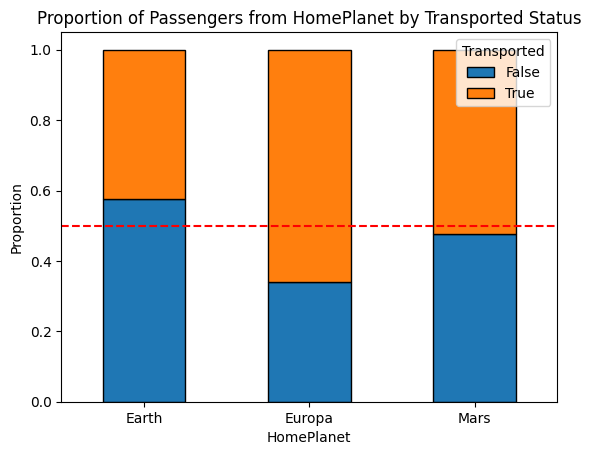

In [43]:
homeplanet_transport_counts = df.groupby(['HomePlanet', 'Transported']).size().unstack().fillna(0)

homeplanet_transport_proportions = homeplanet_transport_counts.div(homeplanet_transport_counts.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
ax = homeplanet_transport_proportions.plot(kind='bar', stacked=True, edgecolor='black')

plt.axhline(y=0.5, color='red', linestyle='--')

plt.title('Proportion of Passengers from HomePlanet by Transported Status')
plt.xlabel('HomePlanet')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Transported')

plt.show()

## Destination

- Check for passengers in same PassengerGroup
- Check for passengers with same surname
- Use mode to imput

In [44]:
display(f'The number of missing Destination Values before is: {df['Destination'].isna().sum()}')

df['Destination'] = df.groupby('PassengerGroup')['Destination'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

display(f'The number of missing Destination Values after is: {df['Destination'].isna().sum()}')

'The number of missing Destination Values before is: 274'

/tmp/ipykernel_88098/305662106.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Destination'] = df.groupby('PassengerGroup')['Destination'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))


'The number of missing Destination Values after is: 154'

In [45]:
def impute_destination(row, df):
    if pd.isna(row['Destination']):
        last_name = row['LastName']
        same_last_name = df[(df['LastName'] == last_name) & (df['Destination'].notna())]
        if not same_last_name.empty:
            return same_last_name['Destination'].values[0]
    return row['Destination']



df['Destination'] = df.apply(lambda row: impute_destination(row, df), axis=1)

display(f'The number of missing Destination Values after is: {df['Destination'].isna().sum()}')

'The number of missing Destination Values after is: 6'

In [46]:
df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])
display(f'The number of missing Destination Values after is: {df['Destination'].isna().sum()}')

'The number of missing Destination Values after is: 0'

<Figure size 1000x600 with 0 Axes>

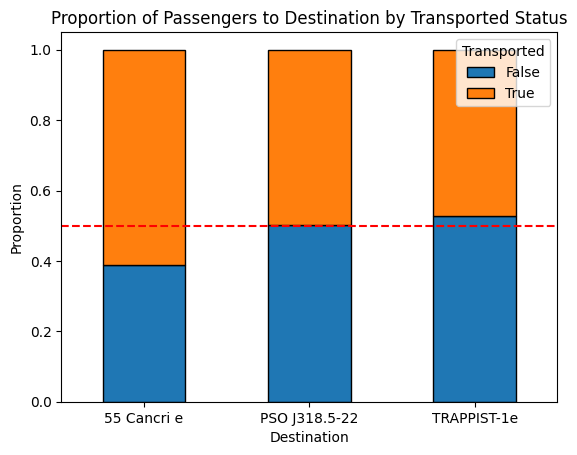

In [47]:
destination_transport_counts = df.groupby(['Destination', 'Transported']).size().unstack().fillna(0)

destination_transport_proportions = destination_transport_counts.div(destination_transport_counts.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
ax = destination_transport_proportions.plot(kind='bar', stacked=True, edgecolor='black')

plt.axhline(y=0.5, color='red', linestyle='--')

plt.title('Proportion of Passengers to Destination by Transported Status')
plt.xlabel('Destination')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Transported')

plt.show()

## Cabin

- This can be split into three (Deck, Num, Side)

In [48]:
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)

df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,GroupSize,Solo,LastName,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,1,1,Ofracculy,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,1,Vines,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,2,0,Susent,A,0,S


### Deck

In [49]:
display(f'The number of missing Deck Values before is: {df['Deck'].isna().sum()}')

df['Deck'] = df.groupby('PassengerGroup')['Deck'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

display(f'The number of missing Deck Values after is: {df['Deck'].isna().sum()}')

def impute_deck(row, df):
    if pd.isna(row['Deck']):
        last_name = row['LastName']
        same_last_name = df[(df['LastName'] == last_name) & (df['Deck'].notna())]
        if not same_last_name.empty:
            return same_last_name['Deck'].values[0]
    return row['Deck']



df['Deck'] = df.apply(lambda row: impute_deck(row, df), axis=1)

missing_decks_after_first_imputation = df['Deck'].isna().sum()
display(f'The number of missing Deck values after first imputation is: {missing_decks_after_first_imputation}')

if missing_decks_after_first_imputation > 0:
    mode_deck = df['Deck'].mode()[0]
    df['Deck'].fillna(mode_deck, inplace=True)

missing_decks_after_mode_imputation = df['Deck'].isna().sum()
display(f'The number of missing Deck values after imputing with mode is: {missing_decks_after_mode_imputation}')

'The number of missing Deck Values before is: 299'

/tmp/ipykernel_88098/530661642.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Deck'] = df.groupby('PassengerGroup')['Deck'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))


'The number of missing Deck Values after is: 162'

'The number of missing Deck values after first imputation is: 5'

/tmp/ipykernel_88098/530661642.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Deck'].fillna(mode_deck, inplace=True)


'The number of missing Deck values after imputing with mode is: 0'

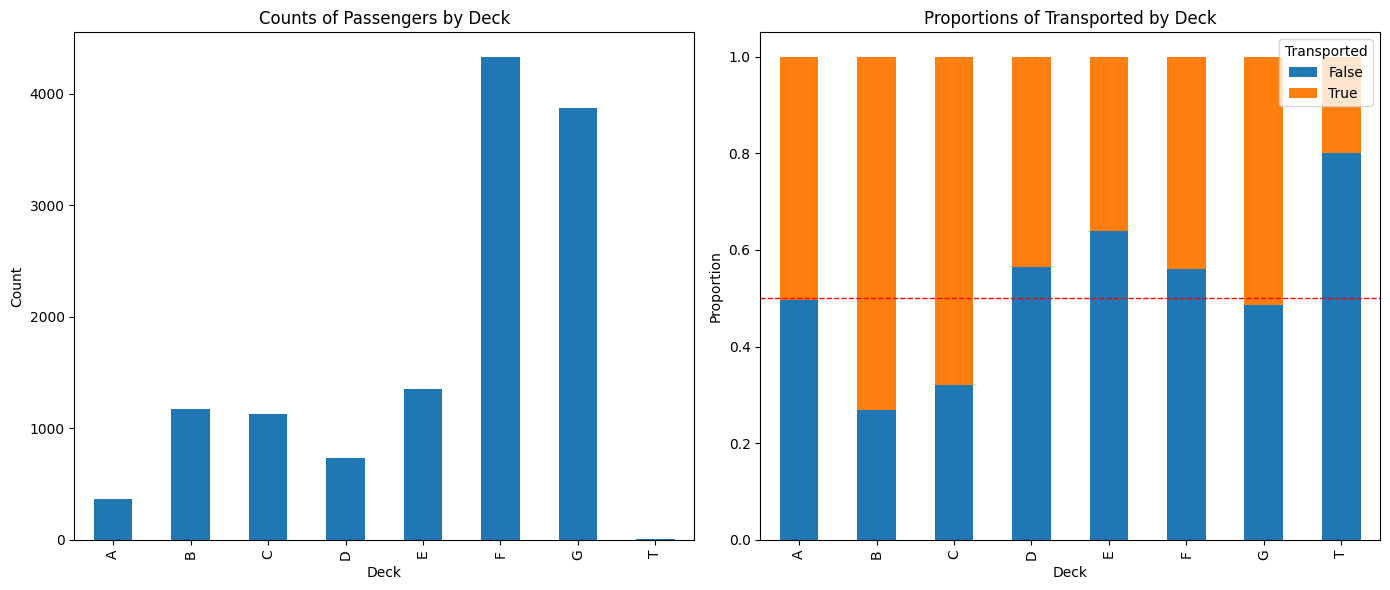

In [50]:
deck_transport = df.groupby(['Deck', 'Transported']).size().unstack(fill_value=0)

deck_transport_norm = deck_transport.div(deck_transport.sum(axis=1), axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

deck_counts = df['Deck'].value_counts().sort_index()
deck_counts.plot(kind='bar', ax=ax[0])
ax[0].set_title('Counts of Passengers by Deck')
ax[0].set_xlabel('Deck')
ax[0].set_ylabel('Count')

deck_transport_norm.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Proportions of Transported by Deck')
ax[1].set_xlabel('Deck')
ax[1].set_ylabel('Proportion')
ax[1].legend(title='Transported')

ax[1].axhline(0.5, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

**Notes**

Passengers in Cabins B and C have a higher chance of being Transported
Passengers in E and T have less chance of being transported

*Decision*

- Group Cabins by chance of Transported

    - **low** - *E, T*
    - **medium** - *A, D, F, G*
    - **high** - *B, C*


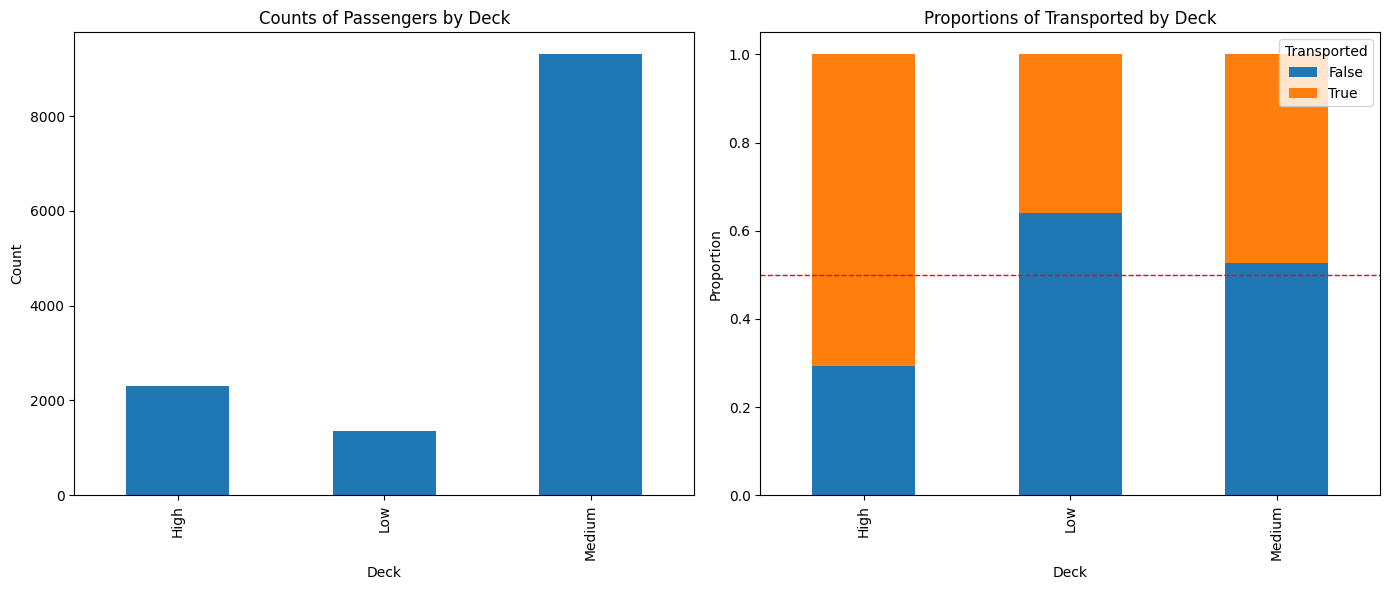

In [51]:
df['Deck'] = df['Deck'].map({'A': 'Medium', 'B': 'High', 'C': 'High', 'D': 'Medium', 'E': 'Low', 'F': 'Medium', 'G': 'Medium', 'T': 'Low'})

deck_transport = df.groupby(['Deck', 'Transported']).size().unstack(fill_value=0)

deck_transport_norm = deck_transport.div(deck_transport.sum(axis=1), axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

deck_counts = df['Deck'].value_counts().sort_index()
deck_counts.plot(kind='bar', ax=ax[0])
ax[0].set_title('Counts of Passengers by Deck')
ax[0].set_xlabel('Deck')
ax[0].set_ylabel('Count')

deck_transport_norm.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Proportions of Transported by Deck')
ax[1].set_xlabel('Deck')
ax[1].set_ylabel('Proportion')
ax[1].legend(title='Transported')

ax[1].axhline(0.5, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

### Side

In [52]:
display(f'The number of missing Side Values before is: {df['Side'].isna().sum()}')

df['Side'] = df.groupby('PassengerGroup')['Side'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

display(f'The number of missing Side Values after is: {df['Side'].isna().sum()}')

def impute_side(row, df):
    if pd.isna(row['Side']):
        last_name = row['LastName']
        same_last_name = df[(df['LastName'] == last_name) & (df['Side'].notna())]
        if not same_last_name.empty:
            return same_last_name['Side'].values[0]
    return row['Side']

df['Side'] = df.apply(lambda row: impute_side(row, df), axis=1)
missing_sides_after_first_imputation = df['Side'].isna().sum()
display(f'The number of missing Side values after first imputation is: {missing_sides_after_first_imputation}')

if missing_sides_after_first_imputation > 0:
    mode_sides = df['Side'].mode()[0]
    df['Side'].fillna(mode_sides, inplace=True)

missing_sides_after_mode_imputation = df['Side'].isna().sum()
display(f'The number of missing Sides values after imputing with mode is: {missing_sides_after_mode_imputation}')

'The number of missing Side Values before is: 299'

/tmp/ipykernel_88098/923372094.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Side'] = df.groupby('PassengerGroup')['Side'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))


'The number of missing Side Values after is: 162'

'The number of missing Side values after first imputation is: 5'

/tmp/ipykernel_88098/923372094.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Side'].fillna(mode_sides, inplace=True)


'The number of missing Sides values after imputing with mode is: 0'

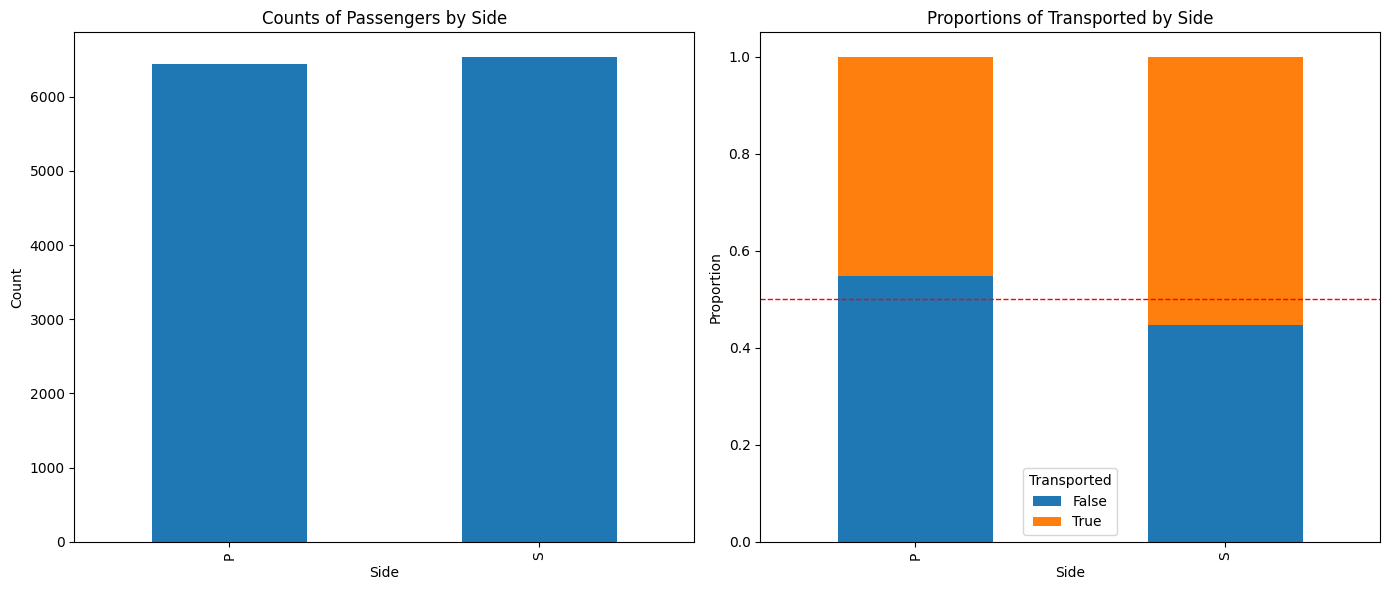

In [53]:
side_transport = df.groupby(['Side', 'Transported']).size().unstack(fill_value=0)

side_transport_norm = side_transport.div(side_transport.sum(axis=1), axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

side_counts = df['Side'].value_counts().sort_index()
side_counts.plot(kind='bar', ax=ax[0])
ax[0].set_title('Counts of Passengers by Side')
ax[0].set_xlabel('Side')
ax[0].set_ylabel('Count')

side_transport_norm.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Proportions of Transported by Side')
ax[1].set_xlabel('Side')
ax[1].set_ylabel('Proportion')
ax[1].legend(title='Transported')

ax[1].axhline(0.5, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

**Notes**

Passengers on Starboard side have a higher chance of being Transported
Passengers on Port side have less chance of being transported


### Num

In [54]:
print(f'The number of missing Num values before is: {df["Num"].isna().sum()}')

df['Num'] = df.groupby('PassengerGroup')['Num'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

print(f'The number of missing Num values after is: {df["Num"].isna().sum()}')


def impute_num(row, df):
    if pd.isna(row['Num']):
        last_name = row['LastName']
        same_last_name = df[(df['LastName'] == last_name) & (df['Num'].notna())]
        if not same_last_name.empty:
            return same_last_name['Num'].values[0]
    return row['Num']

df['Num'] = df.apply(lambda row: impute_num(row, df), axis=1)

missing_num_after_first_imputation = df['Num'].isna().sum()
print(f'The number of missing Num values after first imputation is: {missing_num_after_first_imputation}')

if missing_num_after_first_imputation > 0:
    mode_num = df['Num'].mode()[0]
    df['Num'].fillna(mode_num, inplace=True)

missing_num_after_mode_imputation = df['Num'].isna().sum()
print(f'The number of missing Num values after imputing with mode is: {missing_num_after_mode_imputation}')
df['Num'] = df['Num'].astype(int)

The number of missing Num values before is: 299


/tmp/ipykernel_88098/2644407261.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Num'] = df.groupby('PassengerGroup')['Num'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))


The number of missing Num values after is: 162
The number of missing Num values after first imputation is: 5
The number of missing Num values after imputing with mode is: 0


/tmp/ipykernel_88098/2644407261.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Num'].fillna(mode_num, inplace=True)


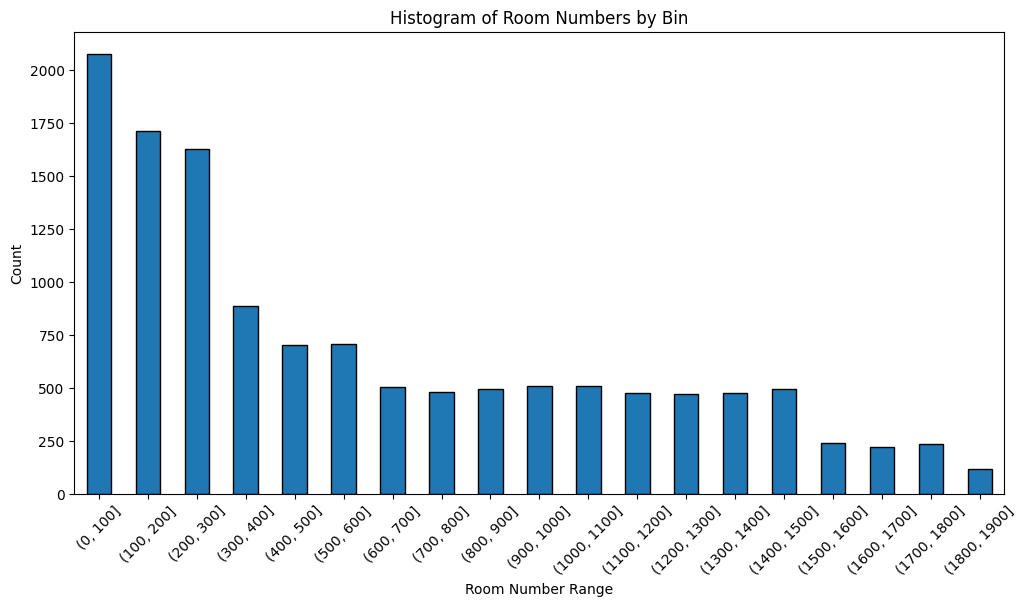

/tmp/ipykernel_88098/3974473589.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_transport_counts = df.groupby(['Num_Bin', 'Transported']).size().unstack().fillna(0)


<Figure size 1200x1200 with 0 Axes>

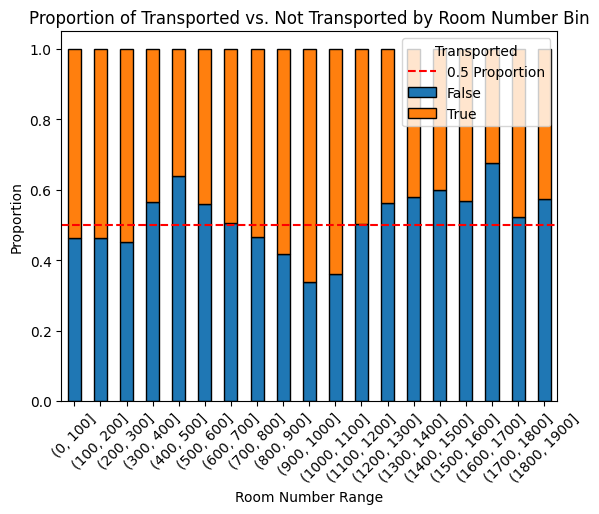

In [55]:
bin_edges = list(range(0, df['Num'].max() + 100, 100))

# Create a new column for the bins
df['Num_Bin'] = pd.cut(df['Num'], bins=bin_edges)

# Count the number of entries in each bin
bin_counts = df['Num_Bin'].value_counts().sort_index()

# Plot histogram of counts per bin
plt.figure(figsize=(12, 6))
bin_counts.plot(kind='bar', edgecolor='black')
plt.title('Histogram of Room Numbers by Bin')
plt.xlabel('Room Number Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Group by bins and Transported status
bin_transport_counts = df.groupby(['Num_Bin', 'Transported']).size().unstack().fillna(0)

# Calculate proportions
bin_transport_proportions = bin_transport_counts.div(bin_transport_counts.sum(axis=1), axis=0)

# Plot histogram with Transported vs. Not Transported as proportions
plt.figure(figsize=(12, 12))
bin_transport_proportions.plot(kind='bar', stacked=True, edgecolor='black')
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='0.5 Proportion')
plt.title('Proportion of Transported vs. Not Transported by Room Number Bin')
plt.xlabel('Room Number Range')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Transported')
plt.show()

In [56]:
def categorise_number(df):
    # Define bin edges
    bin_edges = list(range(0, df['Num'].max() + 100, 100))
    if bin_edges[0] > 0:
        bin_edges = [0] + bin_edges
    
    # Create a new column for the bins with right=False
    df['Num_Bin'] = pd.cut(df['Num'], bins=bin_edges, right=False)
    
    # Count the number of entries in each bin for Transported status
    bin_transport_counts = df.groupby(['Num_Bin', 'Transported']).size().unstack().fillna(0)
    
    # Calculate proportions of transported passengers
    bin_transport_proportions = bin_transport_counts.div(bin_transport_counts.sum(axis=1), axis=0)
    
    # Calculate the proportion of transported passengers
    bin_transport_proportions['Proportion'] = bin_transport_proportions.get(True, 0)
    
    # Define a function to categorize proportions
    def categorise_proportion(prop):
        if prop < 0.4:
            return 'Low'
        elif 0.4 <= prop <= 0.6:
            return 'Medium'
        else:
            return 'High'
    
    # Apply the categorization function
    bin_transport_proportions['NumCategory'] = bin_transport_proportions['Proportion'].apply(categorise_proportion)
    
    # Merge the category back to the original DataFrame
    df = df.merge(bin_transport_proportions[['NumCategory']], left_on='Num_Bin', right_index=True, how='left')
    
    # Drop the Num_Bin column as it's no longer needed
    df.drop(columns=['Num_Bin'], inplace=True)
    
    return df

# Assuming df is your DataFrame
df = categorise_number(df)

/tmp/ipykernel_88098/4092588419.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_transport_counts = df.groupby(['Num_Bin', 'Transported']).size().unstack().fillna(0)


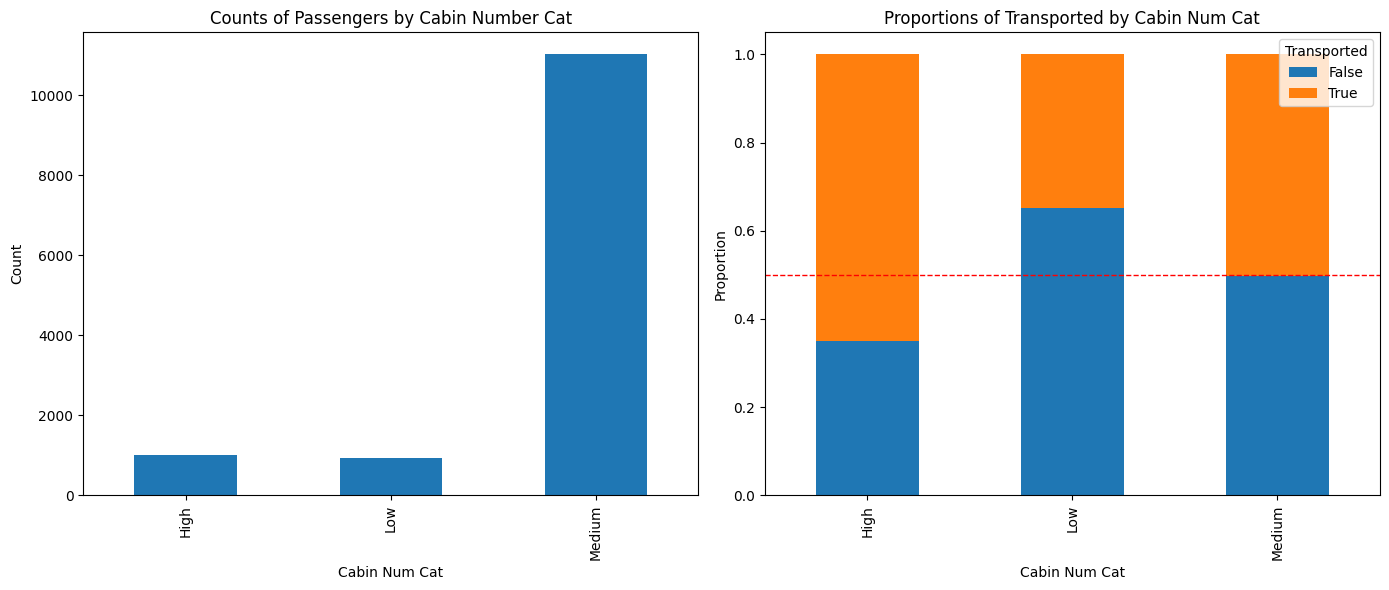

In [57]:
cat_transport = df.groupby(['NumCategory', 'Transported']).size().unstack(fill_value=0)

cat_transport_norm = cat_transport.div(cat_transport.sum(axis=1), axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

cat_counts = df['NumCategory'].value_counts().sort_index()
cat_counts.plot(kind='bar', ax=ax[0])
ax[0].set_title('Counts of Passengers by Cabin Number Cat')
ax[0].set_xlabel('Cabin Num Cat')
ax[0].set_ylabel('Count')

cat_transport_norm.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Proportions of Transported by Cabin Num Cat')
ax[1].set_xlabel('Cabin Num Cat')
ax[1].set_ylabel('Proportion')
ax[1].legend(title='Transported')

ax[1].axhline(0.5, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

**After Categorising the Cabin Number...**

*We can see that there is a clear difference between the thre categories which should provide us with a better foothold*

## Drop Columns

In [58]:
df = df.drop(columns=['Cabin', 'LastName','Name', 'PassengerGroup', 'GroupSize', 'Num'])

# CatBoost Imputation

- CryoSleep
- Age
- RoomService
- FoodCourt
- ShoppingMall
- VRDeck
- Spa

In [59]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df['CryoSleep'] = df['CryoSleep'].astype('float')

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=0)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

imputer = IterativeImputer(estimator=rf_regressor, random_state=0)

numerical_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "VRDeck", "Spa"]

df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

imputer_categorical = IterativeImputer(estimator=rf_classifier, random_state=0)

df['CryoSleep'] = imputer_categorical.fit_transform(df[['CryoSleep']])

df.isna().sum()


/root/code/BigEd12/virtual_envs/machine_learning/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


PassengerId        0
HomePlanet         0
CryoSleep          0
Destination        0
Age                0
VIP              296
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported     4277
Solo               0
Deck               0
Side               0
NumCategory        0
dtype: int64

# Encode and Categorise

## Age

[0, 14, 28, 42, 56, 70, 84]

Age_Bin
(0, 14]     1315
(14, 28]    5637
(28, 42]    3563
(42, 56]    1632
(56, 70]     508
(70, 84]      55
Name: count, dtype: int64

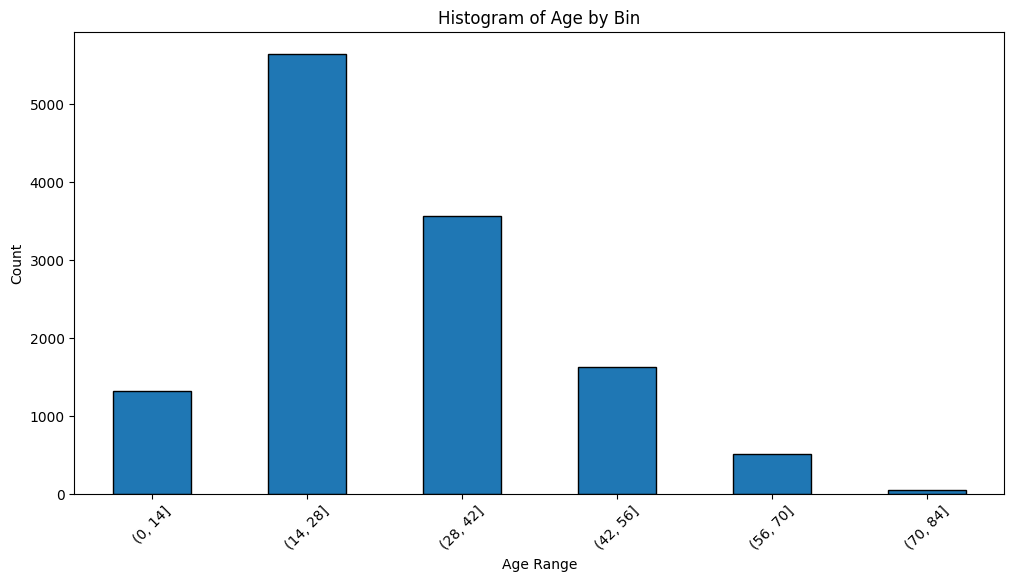

/tmp/ipykernel_88098/457565991.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_transport_counts = df.groupby(['Age_Bin', 'Transported']).size().unstack().fillna(0)


<Figure size 1200x1200 with 0 Axes>

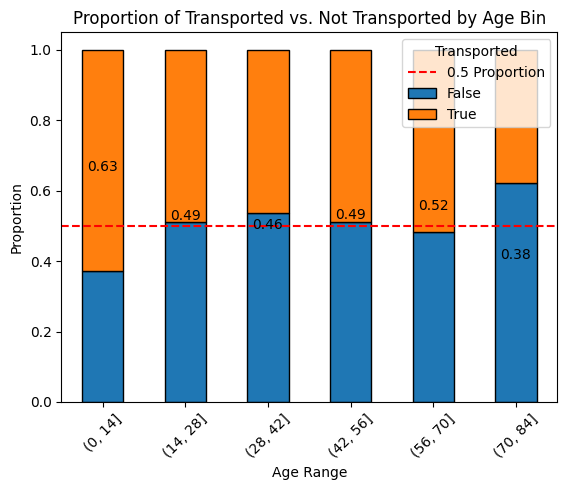

In [60]:
# Calculate max_age and bin_edges
max_age = int(df['Age'].max())  # Ensure max_age is an integer
bin_edges = list(range(0, max_age + 10, 14))
display(bin_edges)

# Create a new column for the bins
df['Age_Bin'] = pd.cut(df['Age'], bins=bin_edges)

# Count the number of entries in each bin
bin_counts = df['Age_Bin'].value_counts().sort_index()
display(bin_counts)

# Plot histogram of counts per bin
plt.figure(figsize=(12, 6))
bin_counts.plot(kind='bar', edgecolor='black')
plt.title('Histogram of Age by Bin')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Group by bins and Transported status
bin_transport_counts = df.groupby(['Age_Bin', 'Transported']).size().unstack().fillna(0)

# Calculate proportions
bin_transport_proportions = bin_transport_counts.div(bin_transport_counts.sum(axis=1), axis=0)

# Plot histogram with Transported vs. Not Transported as proportions
plt.figure(figsize=(12, 12))
ax = bin_transport_proportions.plot(kind='bar', stacked=True, edgecolor='black')

# Add red dashed horizontal line at 0.5
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='0.5 Proportion')

# Add annotations for proportions
for i, (age_bin, row) in enumerate(bin_transport_proportions.iterrows()):
    proportion = row.get(True, 0)  # Get the proportion of 'Transported'
    if not pd.isna(proportion) and proportion > 0:
        # Calculate the height of the bars
        height = proportion
        ax.text(i, height + 0.02, f'{height:.2f}', ha='center', va='bottom')

plt.title('Proportion of Transported vs. Not Transported by Age Bin')
plt.xlabel('Age Range')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Transported')
plt.show()

In [61]:
def categorise_age(df):
    max_age = int(df['Age'].max())  # Ensure max_age is an integer
    bin_edges = list(range(0, max_age + 10, 14))
    
    if bin_edges[0] > 0:
        bin_edges = [0] + bin_edges
    
    # Create a new column for the bins with right=True to match the visualization
    df['Age_Bin'] = pd.cut(df['Age'], bins=bin_edges, right=True)
    
    # Count the number of entries in each bin for Transported status
    bin_transport_counts = df.groupby(['Age_Bin', 'Transported']).size().unstack().fillna(0)
    
    # Calculate proportions of transported passengers
    bin_transport_proportions = bin_transport_counts.div(bin_transport_counts.sum(axis=1), axis=0)
    
    # Calculate the proportion of those transported
    bin_transport_proportions['Proportion'] = bin_transport_proportions.get(True, 0)
    
    # Define a function to categorize proportions
    def categorise_proportion(prop):
        if prop < 0.4:
            return 'Low'
        elif 0.4 <= prop <= 0.6:
            return 'Medium'
        else:
            return 'High'
    
    # Apply the categorization function
    bin_transport_proportions['AgeCategory'] = bin_transport_proportions['Proportion'].apply(categorise_proportion)
    
    # Merge the category back to the original DataFrame
    df = df.merge(bin_transport_proportions[['AgeCategory']], left_on='Age_Bin', right_index=True, how='left')
    
    # Drop the Age_Bin column as it's no longer needed
    df.drop(columns=['Age_Bin'], inplace=True)
    
    return df


df = categorise_age(df)

/tmp/ipykernel_88098/236837385.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_transport_counts = df.groupby(['Age_Bin', 'Transported']).size().unstack().fillna(0)


In [66]:
def fill_missing_age_cat(df):
    # Filter rows where AgeCategory is NaN
    nan_df = df[df['AgeCategory'].isna()]
    
    # Update AgeCategory to 'High' where Age is 0
    df.loc[(df['AgeCategory'].isna()) & (df['Age'] == 0), 'AgeCategory'] = 'High'
    
    return df

# Assuming df is your DataFrame
df = fill_missing_age_cat(df)

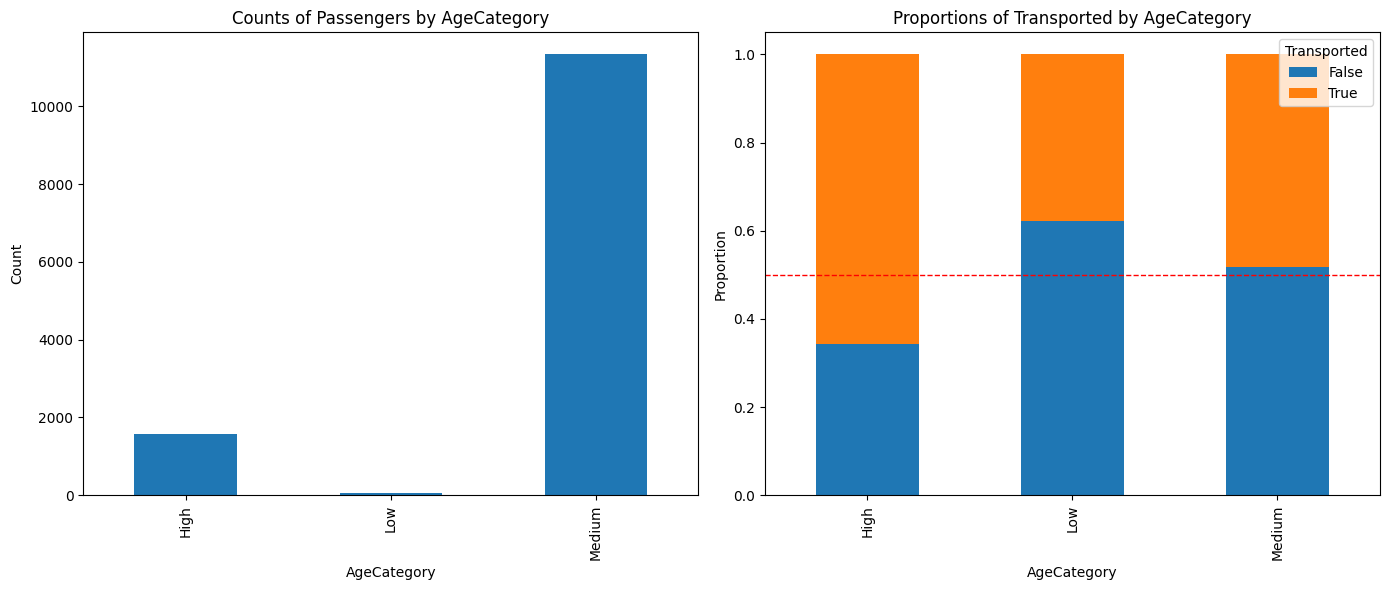

In [69]:
age_transport = df.groupby(['AgeCategory', 'Transported']).size().unstack(fill_value=0)

age_transport_norm = age_transport.div(age_transport.sum(axis=1), axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

age_counts = df['AgeCategory'].value_counts().sort_index()
age_counts.plot(kind='bar', ax=ax[0])
ax[0].set_title('Counts of Passengers by AgeCategory')
ax[0].set_xlabel('AgeCategory')
ax[0].set_ylabel('Count')

age_transport_norm.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Proportions of Transported by AgeCategory')
ax[1].set_xlabel('AgeCategory')
ax[1].set_ylabel('Proportion')
ax[1].legend(title='Transported')

ax[1].axhline(0.5, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

## VIP

In [70]:
# Add Total Spend column from expenditure
df['TotalSpend'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

# Split into VIP and None VIP DFs
df_vip = df[df['VIP'] == True]
df_no_vip = df[df['VIP'] == False]

display(df_vip.shape, df_no_vip.shape)
f'The mean amount of money spent by VIPs was: {df_vip['TotalSpend'].mean()}'
# Find Null Entries
vip_null_mask = df['VIP'].isna()

# If the total spend is over 4000, is a VIP
df.loc[vip_null_mask, 'VIP'] = df.loc[vip_null_mask, 'TotalSpend'] >= df_vip['TotalSpend'].mean() - 500

(273, 18)

(12401, 18)

### Booleans

In [71]:
df['VIP'] = df['VIP'].astype('float')
df['Solo'] = df['Solo'].astype('float')

df['Side'] = df['Side'].map({'P': 0, 'S': 1})

### Categories

In [72]:
df['Deck'] = df['Deck'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['NumCategory'] = df['NumCategory'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['HomePlanet'] = df['HomePlanet'].map({'Earth': 0, 'Mars': 1, 'Europa': 2})
df['AgeCategory'] = df['AgeCategory'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['Destination'] = df['Destination'].map({'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2})

# Drop Last Columns

- Age
- RoomService
- FoodCourt
- ShoppingMall
- Spa
- VRDeck

In [73]:
df = df.drop(columns=['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

In [74]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,Transported,Solo,Deck,Side,NumCategory,AgeCategory,TotalSpend
0,0001_01,2,0.0,0,0.0,False,1.0,2,0,1,1,0.0
1,0002_01,0,0.0,0,0.0,True,1.0,1,1,1,1,736.0
2,0003_01,2,0.0,0,1.0,False,0.0,1,1,1,1,10383.0
3,0003_02,2,0.0,0,0.0,False,0.0,1,1,1,1,5176.0
4,0004_01,0,0.0,0,0.0,True,1.0,1,1,1,1,1091.0


# Divide Into Train and Test

In [75]:
train_preprocessed = df[:len_train].copy()
test_preprocessed = df[len_train:].copy()

train_preprocessed.reset_index(drop=True, inplace=True)
test_preprocessed.reset_index(drop=True, inplace=True)

test_preprocessed.drop(columns=['Transported'], inplace=True)

len(test) == len(test_preprocessed)
test_preprocessed.head(3)

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,Solo,Deck,Side,NumCategory,AgeCategory,TotalSpend
0,0013_01,0,1.0,0,0.0,1.0,1,1,1,1,0.0
1,0018_01,0,0.0,0,0.0,1.0,1,1,1,1,2832.0
2,0019_01,2,1.0,2,0.0,1.0,2,1,1,1,0.0


# Save New DFs

In [76]:
train_preprocessed.to_csv('../../data/preproc_data/train_2_0.csv', index=False)
test_preprocessed.to_csv('../../data/preproc_data/test_2_0.csv', index=False)